In [19]:
import pandas as pd

df = pd.read_csv('Homicides.csv')
df.drop(['Region', 'Subregion', 'Dimension', 'Category', 'Year', 'Unit of measurement', 'Source'], axis=1, inplace=True)
df.head()

country = df.groupby(by='Country')['VALUE'].sum()
country

Country
Afghanistan                           2570.0
Albania                                394.0
Algeria                               5353.0
Andorra                                  4.0
Antigua and Barbuda                     88.0
                                       ...  
Uruguay                               3978.0
Uzbekistan                            1258.0
Vanuatu                                  4.0
Venezuela (Bolivarian Republic of)    8384.0
Zimbabwe                              1560.0
Name: VALUE, Length: 139, dtype: float64

In [20]:
# Religion
import numpy as np

religion = pd.read_csv('religion.csv')
religion.drop(['Region', 'Level', 'Countrycode'], axis=1, inplace=True)
religion.query('Year == 2020', inplace=True)

religion['Population'] = (
    religion['Population']
    .astype(str)
    .str.replace(',', '', regex=False)         
)
religion['Religiously_unaffiliated'] = (
    religion['Religiously_unaffiliated']
    .astype(str)
    .str.replace(',', '', regex=False)
)

religion['Religion Density'] = 1 - (religion['Religiously_unaffiliated'].astype(int) / religion['Population'].astype(int))
religion

,Country,Year,Population,Christians,Muslims,Religiously_unaffiliated,Buddhists,Hindus,Jews,Other_religions,Religion Density
1,All World,2020,7885807101,"2,268,860,679","2,022,590,461",1905359982,"324,185,581","1,177,861,089","14,779,638","172,169,677",0.758381
3,All Asia-Pacific,2020,4544798237,"268,839,155","1,187,663,747",1492753842,"316,111,123","1,166,709,664","185,058","112,535,650",0.671547
5,All Europe,2020,752957406,"505,138,687","45,505,934",190322687,"2,539,594","2,152,636","1,277,202","6,020,665",0.747233
7,All Latin America-Caribbean,2020,646240245,"546,922,208","753,352",77150335,"326,820","695,342","390,861","20,001,329",0.880617
9,All Middle East-North Africa,2020,439686888,"12,918,830","414,112,362",1858569,"88,708","3,223,451","6,788,404","696,565",0.995773
...,...,...,...,...,...,...,...,...,...,...,...
407,Vietnam,2020,98079191,"8,170,016","70,694",66373765,"22,578,634","40,495",125,"845,463",0.323264
409,Western Sahara,2020,549365,847,"546,903",1390,0,0,0,225,0.997470
411,Yemen,2020,36134864,"20,138","36,085,366",22243,197,"2,798",73,"4,047",0.999384
413,Zambia,2020,19059395,"18,731,646","97,449",11389,363,"3,061",191,"215,296",0.999402


In [21]:
# Sex
sex = pd.read_csv('Sex.csv')
sex.drop(['Iso3_code', 'Region', 'Subregion', 'Indicator', 'Dimension', 'Category'], axis=1, inplace=True)
sex = sex.groupby(by='Country')['VALUE'].sum()
sex

Country
Albania                                 1055
Algeria                                11948
Antigua and Barbuda                      183
Argentina                             191104
Armenia                                  412
                                      ...   
United Kingdom (Northern Ireland)      21977
United Kingdom (Scotland)              29045
United States of America             1047935
Uruguay                                 6998
Uzbekistan                              1382
Name: VALUE, Length: 108, dtype: int64

In [22]:
# Corruption 
corruption = pd.read_csv('Corruption.csv')
corruption.query('`Unit of measurement` == "Counts"', inplace=True)
corruption = corruption.groupby(by='Country')['VALUE'].sum()
corruption

Country
Albania                                7276.0
Algeria                                4208.0
Antigua and Barbuda                     919.0
Argentina                            229808.0
Armenia                                2279.0
                                       ...   
United Kingdom (Northern Ireland)     25063.0
United Kingdom (Scotland)            108546.0
United States of America               9393.0
Uruguay                              146276.0
Uzbekistan                              158.0
Name: VALUE, Length: 107, dtype: float64

In [23]:
# Merging
merged_df = pd.merge(religion, country, how='inner', on=['Country'])
merged_df = pd.merge(merged_df, sex, how='inner', on=['Country'], suffixes=('_hom', '_sex'))
merged_df = pd.merge(merged_df, corruption, how='inner', on=['Country'])
merged_df['Homicide Density'] = merged_df['VALUE_hom'].astype(int) / merged_df['Population'].astype(int) * 100
merged_df['Sex Assault Density'] = merged_df['VALUE_sex'].astype(int) / merged_df['Population'].astype(int) * 100
merged_df = merged_df.rename(columns={'VALUE': 'VALUES_corr'})
merged_df['Corruption Density'] = merged_df['VALUES_corr'].astype(int) / merged_df['Population'].astype(int) * 100
# merged_df.sort_values(by='Homicide Density', ascending=False)
merged_df



,Country,Year,Population,Christians,Muslims,Religiously_unaffiliated,Buddhists,Hindus,Jews,Other_religions,Religion Density,VALUE_hom,VALUE_sex,VALUES_corr,Homicide Density,Sex Assault Density,Corruption Density
0,Albania,2020,2871954,"511,657","2,139,813",219787,5,20,289,382,0.923471,394.0,1055,7276.0,0.013719,0.036735,0.253347
1,Algeria,2020,44042091,"129,920","43,329,641",557664,"6,607",0,57,"18,202",0.987338,5353.0,11948,4208.0,0.012154,0.027129,0.009554
2,Argentina,2020,45191965,"39,974,074","419,922",4172533,"14,038","1,163","173,979","436,255",0.907671,24582.0,191104,229808.0,0.054395,0.422872,0.508515
3,Armenia,2020,2890893,"2,813,205","7,712",34051,309,216,103,"35,296",0.988221,248.0,412,2279.0,0.008579,0.014252,0.078834
4,Australia,2020,25743791,"12,035,331","901,843",10900956,"672,312","762,897","108,230","362,221",0.576560,1506.0,111312,678150.0,0.005850,0.432384,2.634227
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,Trinidad and Tobago,2020,1481024,"1,036,976","80,927",36264,435,"305,346",293,"20,783",0.975514,4236.0,1360,4419.0,0.286018,0.091828,0.298375
76,Ukraine,2020,44680015,"37,276,433","253,705",6766595,"149,418","5,658","42,764","185,442",0.848554,1698.0,3645,180329.0,0.003800,0.008158,0.403601
77,United Arab Emirates,2020,9448524,"1,352,428","6,891,776",31731,"15,792","1,110,535","1,418","44,843",0.996642,280.0,644,394.0,0.002963,0.006816,0.004170
78,Uruguay,2020,3398968,"1,512,245","3,035",1781393,0,0,"16,256","86,039",0.475902,3978.0,6998,146276.0,0.117036,0.205886,4.303542


In [51]:
df.head()
df.dtypes


Country                      object
Year                          int64
Population                  float64
Christians                  float64
Muslims                     float64
Religiously_unaffiliated     object
Buddhists                   float64
Hindus                      float64
Jews                        float64
Other_religions             float64
Religion Density            float64
VALUE_hom                   float64
VALUE_sex                     int64
VALUES_corr                 float64
Homicide Density            float64
Sex Assault Density         float64
Corruption Density          float64
Pop_scaled                  float64
Religious                   float64
NonReligious                 object
Rel_scaled                  float64
dtype: object

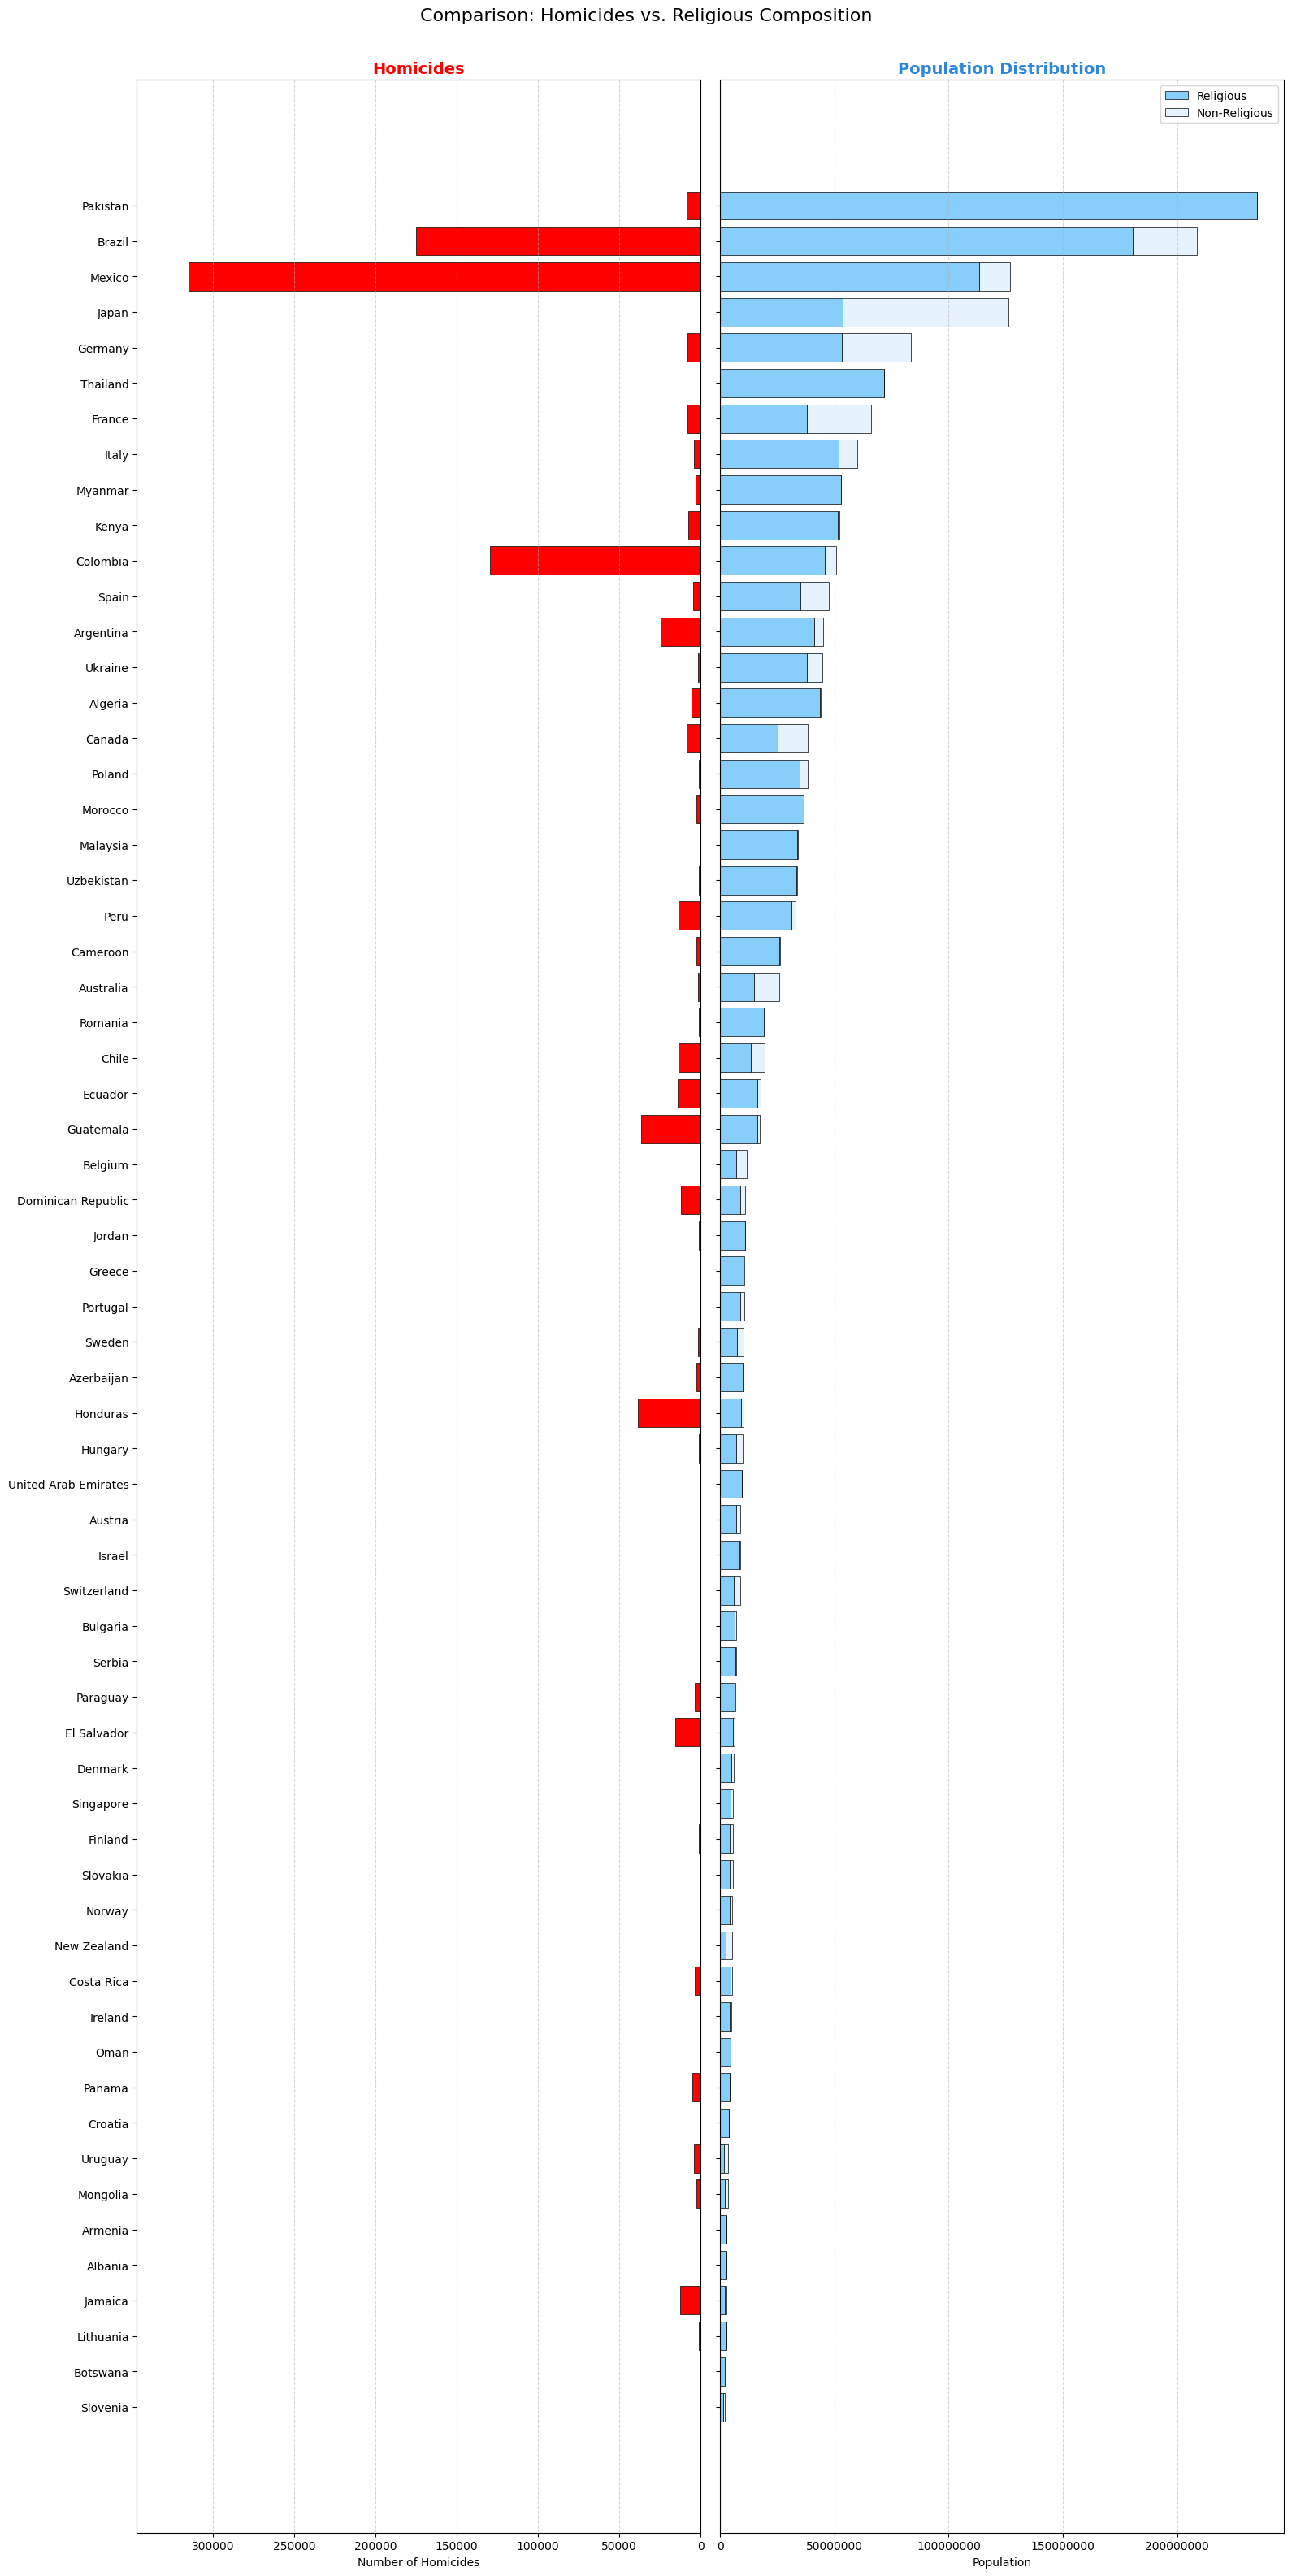

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
# Ensure 'final_1.csv' is in the same directory as this script
df = pd.read_csv('final_1.csv')

# 2. Data Cleaning
# Remove commas from number strings and convert to actual numbers
cols_to_clean = ['Christians', 'Muslims', 'Buddhists', 'Hindus', 'Jews', 
                 'Other_religions', 'VALUE_hom']

for col in cols_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# 3. Filter Data
# Exclude countries with population < 2 million to remove outliers
df_filtered = df[df['Population'] > 2000000].copy()

# 4. Prepare Variables for Plotting
# Define "Non-Religious" using the 'Religiously_unaffiliated' column
df_filtered['Non_Religious_Count'] = df_filtered['Religiously_unaffiliated']
# Define "Religious" as the remainder of the population
df_filtered['Religious_Count'] = df_filtered['Population'] - df_filtered['Non_Religious_Count']

# Sort by Population so the largest bars are at the top
df_sorted = df_filtered.sort_values(by='Population', ascending=True)

# 5. Create the Double-Sided Graph
# Create two subplots side-by-side sharing the Y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, len(df_sorted) * 0.5), sharey=True)

# --- LEFT SIDE: HOMICIDES ---
# Plot Homicides in RED
ax1.barh(df_sorted['Country'], df_sorted['VALUE_hom'], color='#FF0000', edgecolor='black', linewidth=0.5)

# Formatting Left Side
# Reverse the x-axis limits (Max -> 0) so bars grow to the left
ax1.set_xlim(max(df_sorted['VALUE_hom']) * 1.1, 0)
ax1.set_xlabel('Number of Homicides')
ax1.set_title('Homicides', fontsize=14, fontweight='bold', color='#FF0000')
ax1.grid(axis='x', linestyle='--', alpha=0.5)

# --- RIGHT SIDE: RELIGIOUS vs NON-RELIGIOUS POPULATION ---
# Stacked Bar Chart
# 1. Plot Religious count first (Light Blue)
p1 = ax2.barh(df_sorted['Country'], df_sorted['Religious_Count'], color='#87CEFA', label='Religious', edgecolor='black', linewidth=0.5)

# 2. Plot Non-Religious count "on top" / to the right (Lighter Blue)
p2 = ax2.barh(df_sorted['Country'], df_sorted['Non_Religious_Count'], left=df_sorted['Religious_Count'], color='#E6F3FF', label='Non-Religious', edgecolor='black', linewidth=0.5)

# Formatting Right Side
ax2.set_xlabel('Population')
ax2.set_title('Population Distribution', fontsize=14, fontweight='bold', color='#2e86de')
ax2.legend()
ax2.grid(axis='x', linestyle='--', alpha=0.5)
# Format x-axis to use plain numbers (prevent scientific notation like 1e8)
ax2.ticklabel_format(style='plain', axis='x')

# --- GLOBAL LAYOUT ADJUSTMENTS ---
# Remove the space between the two plots to make them look like one continuous chart
plt.subplots_adjust(wspace=0.0) 

# Add a main title for the whole figure
plt.suptitle('Comparison: Homicides vs. Religious Composition', fontsize=16, y=1.005)

plt.tight_layout()
plt.show()

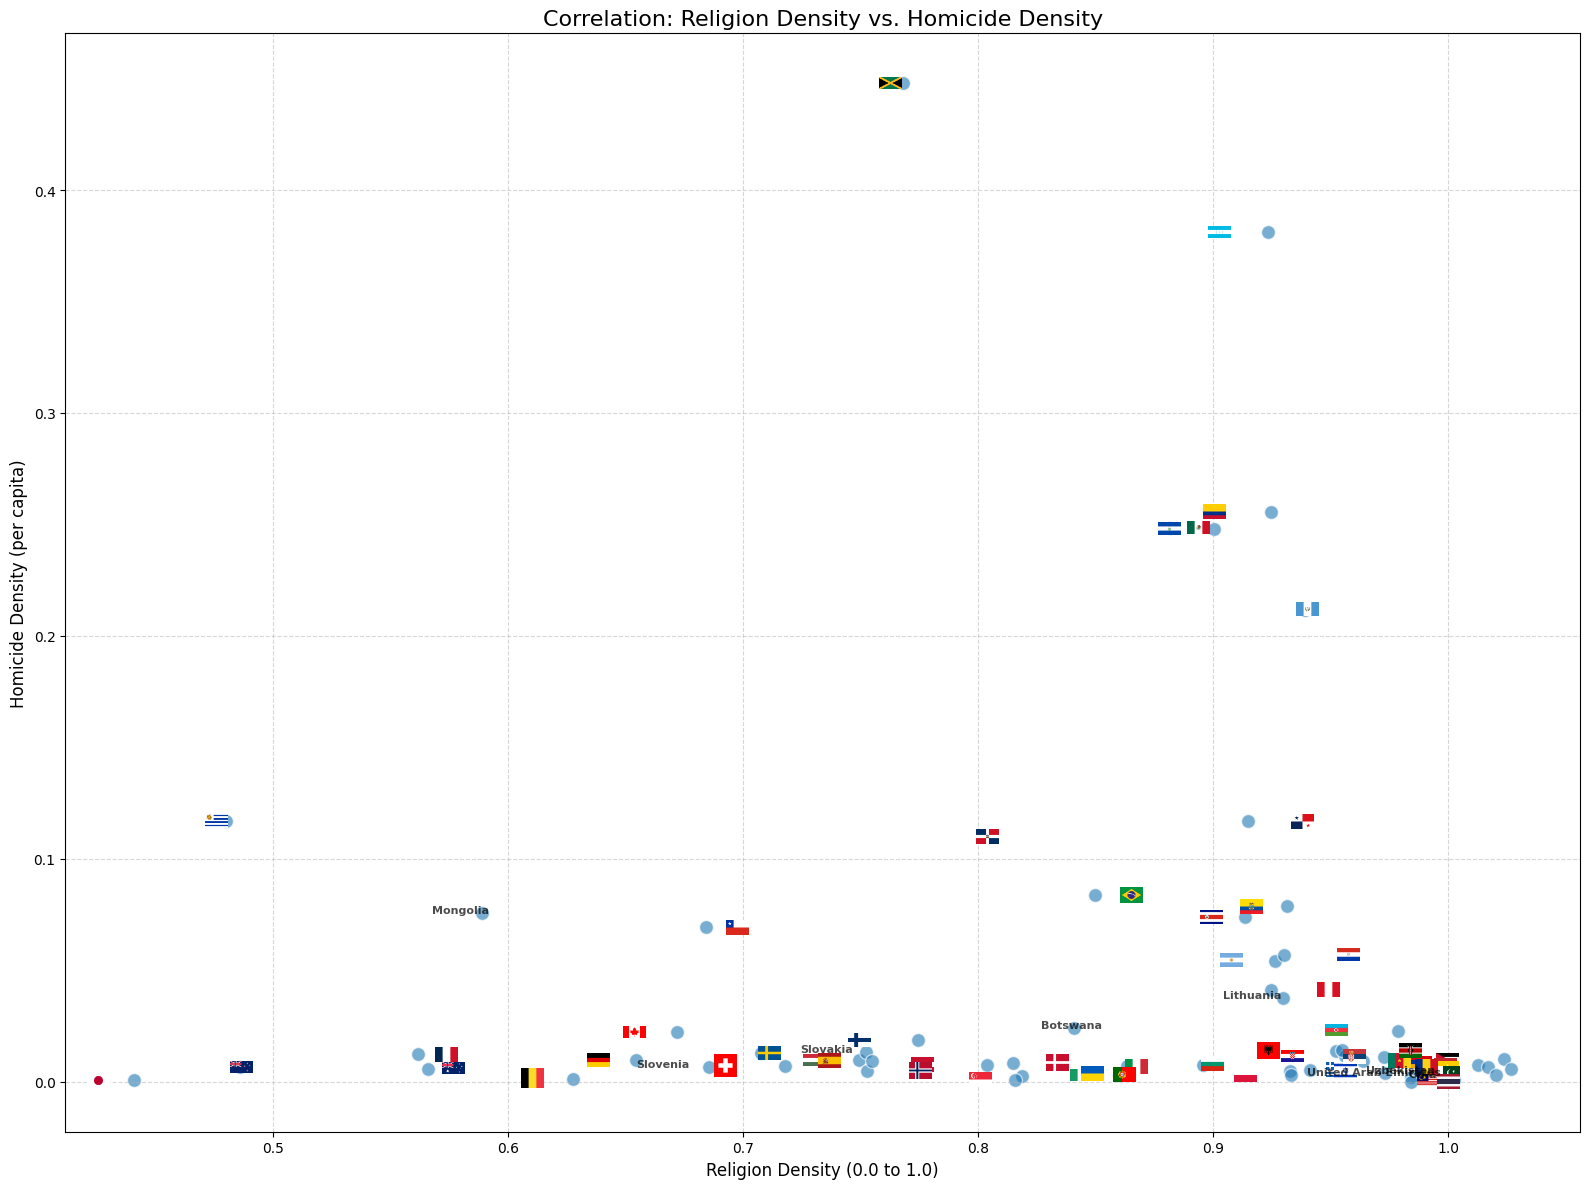

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from io import BytesIO
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 1. Load Data
df = pd.read_csv('final_1.csv')

# 2. Data Cleaning
cols_to_clean = ['Christians', 'Muslims', 'Buddhists', 'Hindus', 'Jews', 
                 'Other_religions', 'VALUE_hom']

for col in cols_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# 3. Filter Data
# Keeping your consistency of removing countries < 2 Million
df_filtered = df[df['Population'] > 2000000].copy()

# 4. Prepare Data for Correlation
x_data = df_filtered['Religion Density']
y_data = df_filtered['Homicide Density']

# 5. Create the Jittered Scatter Plot
# Increased figure size significantly to accommodate more flags
plt.figure(figsize=(16, 12))

sns.regplot(
    x=x_data, 
    y=y_data, 
    data=df_filtered,
    x_jitter=0.03,
    fit_reg=False, # This removes the regression line
    scatter_kws={
        'alpha': 0.6,
        's': 100,
        'edgecolor': 'w'
    },
    color='#1f77b4'
)

plt.title('Correlation: Religion Density vs. Homicide Density', fontsize=16)
plt.xlabel('Religion Density (0.0 to 1.0)', fontsize=12)
plt.ylabel('Homicide Density (per capita)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# --- FLAG GENERATION LOGIC ---

# Expanded mapping of Country Name -> ISO 2-letter code
country_codes = {
    # Americas
    "United States": "us", "Canada": "ca", "Mexico": "mx", "Brazil": "br", "Argentina": "ar",
    "Colombia": "co", "Venezuela": "ve", "Chile": "cl", "Peru": "pe", "Ecuador": "ec",
    "Bolivia": "bo", "Paraguay": "py", "Uruguay": "uy", "Guatemala": "gt", "Honduras": "hn",
    "El Salvador": "sv", "Nicaragua": "ni", "Costa Rica": "cr", "Panama": "pa", "Cuba": "cu",
    "Dominican Republic": "do", "Haiti": "ht", "Jamaica": "jm", "Trinidad and Tobago": "tt",
    
    # Europe
    "United Kingdom": "gb", "France": "fr", "Germany": "de", "Italy": "it", "Spain": "es",
    "Portugal": "pt", "Netherlands": "nl", "Belgium": "be", "Switzerland": "ch", "Austria": "at",
    "Sweden": "se", "Norway": "no", "Denmark": "dk", "Finland": "fi", "Ireland": "ie",
    "Poland": "pl", "Czech Republic": "cz", "Hungary": "hu", "Romania": "ro", "Bulgaria": "bg",
    "Greece": "gr", "Russia": "ru", "Ukraine": "ua", "Belarus": "by", "Turkey": "tr",
    "Albania": "al", "Armenia": "am", "Serbia": "rs", "Croatia": "hr", "Bosnia and Herzegovina": "ba",
    
    # Asia & Oceania
    "China": "cn", "Japan": "jp", "India": "in", "South Korea": "kr", "North Korea": "kp",
    "Indonesia": "id", "Pakistan": "pk", "Bangladesh": "bd", "Philippines": "ph", "Vietnam": "vn",
    "Thailand": "th", "Myanmar": "mm", "Malaysia": "my", "Singapore": "sg", "Australia": "au",
    "New Zealand": "nz", "Afghanistan": "af", "Iran": "ir", "Iraq": "iq", "Saudi Arabia": "sa",
    "Israel": "il", "Syria": "sy", "Yemen": "ye", "Jordan": "jo", "Lebanon": "lb", "Kazakhstan": "kz",
    "Azerbaijan": "az", "Sri Lanka": "lk", "Nepal": "np",
    
    # Africa
    "Nigeria": "ng", "Egypt": "eg", "South Africa": "za", "Kenya": "ke", "Ethiopia": "et",
    "Ghana": "gh", "Tanzania": "tz", "Algeria": "dz", "Morocco": "ma", "Sudan": "sd",
    "Uganda": "ug", "Congo": "cg", "Democratic Republic of the Congo": "cd", "Cameroon": "cm",
    "Tunisia": "tn", "Libya": "ly"
}

def get_flag(name):
    """Fetches a flag image from flagcdn.com based on country name."""
    code = country_codes.get(name)
    if not code:
        return None 
    try:
        url = f"https://flagcdn.com/w40/{code}.png"
        response = requests.get(url, timeout=3)
        img = plt.imread(BytesIO(response.content), format='png')
        return img
    except Exception as e:
        return None

# Loop through ALL countries in the filtered list
for i, row in df_filtered.iterrows():
    img = get_flag(row['Country'])
    
    if img is not None:
        # Reduced zoom to 0.4 to prevent massive overlapping
        imagebox = OffsetImage(img, zoom=0.4) 
        ab = AnnotationBbox(imagebox, (row['Religion Density'], row['Homicide Density']), frameon=False, pad=0)
        plt.gca().add_artist(ab)
    else:
        # Fallback to text
        plt.text(
            row['Religion Density'], 
            row['Homicide Density'], 
            row['Country'], 
            fontsize=8, 
            fontweight='bold', 
            ha='right',
            alpha=0.7
        )

plt.tight_layout()
plt.show()


In [80]:
df.dtypes   

Country                      object
Year                          int64
Population                    int64
Christians                    int64
Muslims                       int64
Religiously_unaffiliated      int64
Buddhists                     int64
Hindus                        int64
Jews                          int64
Other_religions               int64
Religion Density            float64
VALUE_hom                   float64
VALUE_sex                     int64
VALUES_corr                 float64
Homicide Density            float64
Sex Assault Density         float64
Corruption Density          float64
dtype: object

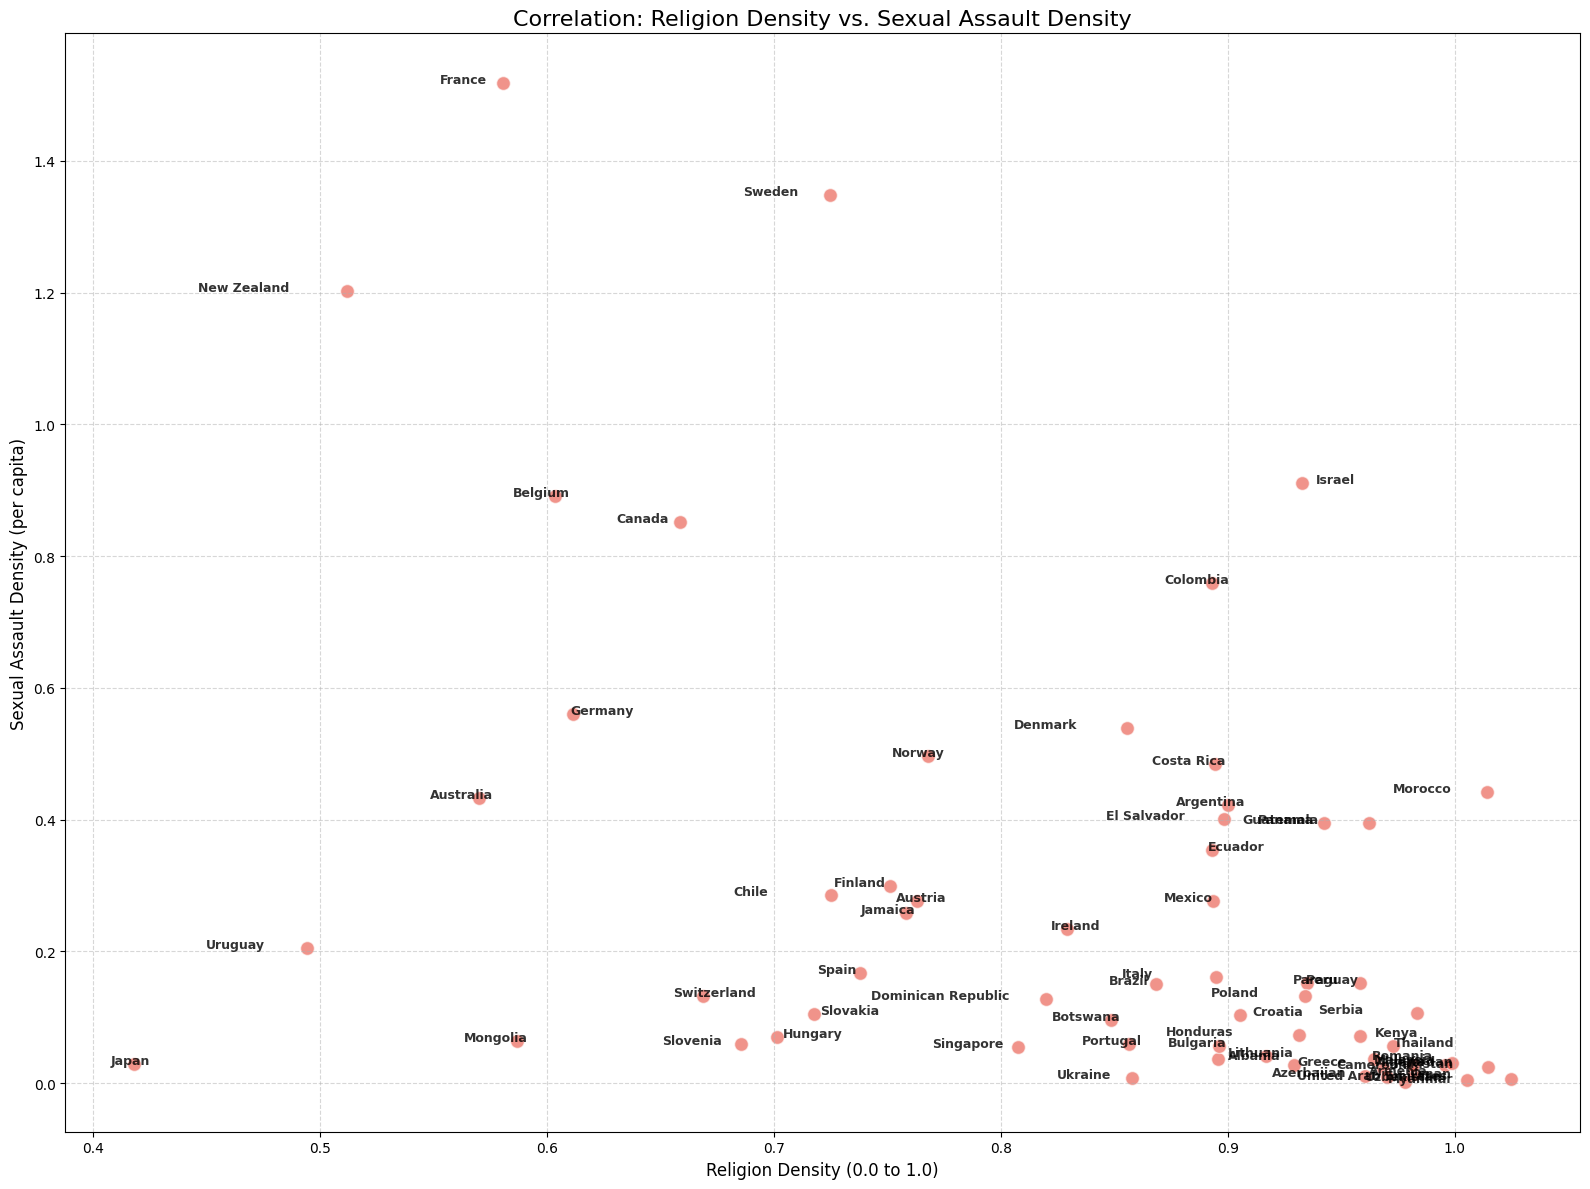

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Load Data
df = pd.read_csv('final_1.csv')

# 2. Data Cleaning
cols_to_clean = ['Christians', 'Muslims', 'Buddhists', 'Hindus', 'Jews', 
                 'Other_religions', 'VALUE_hom', 'Sex Assault Density']

for col in cols_to_clean:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')

# 3. Filter Data
# Keeping your consistency of removing countries < 2 Million
df_filtered = df[df['Population'] > 2000000].copy()

# 4. Prepare Data for Correlation
x_data = df_filtered['Religion Density']
y_data = df_filtered['Sex Assault Density']

# 5. Create the Jittered Scatter Plot
plt.figure(figsize=(16, 12))

sns.regplot(
    x=x_data, 
    y=y_data, 
    data=df_filtered,
    x_jitter=0.03,
    fit_reg=False, 
    scatter_kws={
        'alpha': 0.6,
        's': 100,
        'edgecolor': 'w'
    },
    color='#e74c3c'
)

plt.title('Correlation: Religion Density vs. Sexual Assault Density', fontsize=16)
plt.xlabel('Religion Density (0.0 to 1.0)', fontsize=12)
plt.ylabel('Sexual Assault Density (per capita)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# --- TEXT LABEL LOGIC ---

# Loop through ALL countries in the filtered list and add text labels
for i, row in df_filtered.iterrows():
    plt.text(
        row['Religion Density'], 
        row['Sex Assault Density'], 
        row['Country'], 
        fontsize=9, 
        fontweight='bold', 
        ha='right', # Align text to the right of the dot
        alpha=0.8
    )

plt.tight_layout()
plt.show()